## Part 2 begins here.

Note: this notebook is too big; should have been done in two parts.  Detailed contents at the end.

Load and reindex by date_installed after checking no nulls.  I want to see if null data in the date_installed column was a one-time thing.

Will there be any change in the mixed type warnings (because of removing misaligned rows)?   


* Load data

* Examine <a href="#Install_type">Install_type</a>.
    Many install types exist in data.  Top two types are residential and commercial.

* Pull out <a href="#Residential">residential</a> and commercial data into their own dataframes.
    * Examine relationships among price_per_watt, size and cost.  Data is dirty, but masking out top and bottom 1% cleans it up nicely, while not losing much data.
    * Breaking out the data for residential did not clean up the distributions.  Masking away the top and bottom 1% brings us much closer to a working set.  It will be interesting to see what happens when the same approach is applied to commercial installations, the next largest group.
    
*  Examine <a href="#Geo">geograpical</a> variables
    * state                          
        Make all into 2-character strings. Check.
    * zipcode                        
        Make all into 5-character strings with leading zeros.  Check.
    * city                           
        Save for EDA
    * county                         
        Save for EDA
    
* Examine <a href="#Other">other</a> variables
    * installer:
        keep for now, though we may not do anything with it
    * new_constr:
        keep for now, though we may not do anything with it
    * tracking: 
        keep for now, though we may not do anything with it
    * 3rd_party:
        keep for sure; there are enough to make the question of price divergence interesting
 
* Examine <a href="#Possible">possibly</a> usable fields

##### Divide into 3 groups 
1. keepers
    * date_installed
    * cost_per_watt
    * size_kw
    * cost
<br>
    * state
    * zipcode
    * city
    * county
<br>
    * appraised
    * install_type
    * new_const
    * tracking
    * 3rd_party
2. decide later
    * incentive_prog_names
    * utility_clean
    * tech_1
    * model1_clean
    * installer
    * bipv_1
3. don't keep
    * type 
    * lbnl_tts_version_year 
    * lbnl_tts 
    * annual_PV_prod 
    * annual_insolation 
    * rebate 
    * sales_tax_cost 
    * tilt1 
    * tracking_type 
    * azimuth1 
    * manuf2_clean
    * manuf3_clean
    * manuf1_clean 
    * inv_man_clean 
    * reported_annual_energy_prod 
    * year 
    * pbi_length 
    * utility 
    * bipv_3 
    * bipv_2 


### Start by loading up

In [1]:
# set up
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
dfFull = pd.read_csv('../local/data/live_20171219_1.csv', index_col='date_installed', parse_dates=True)

C:\Users\saus\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# check that index contains no null entries
dfFull.index.isnull().sum()

0

In [4]:
# this doesn't modify the file.
dfFull.sort_index(inplace=True)

In [5]:
dfFull.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1020516 entries, 1909-07-07 to 2017-11-25
Data columns (total 37 columns):
state                          1020516 non-null object
incentive_prog_names           797958 non-null object
size_kw                        1020516 non-null float64
appraised                      224036 non-null object
zipcode                        1020516 non-null int64
install_type                   977940 non-null object
installer                      702466 non-null object
cost_per_watt                  762941 non-null float64
cost                           763102 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           798954 non-null object
utility_clean                  792717 non-null object
tech_1                         580917 non-null object
model1_clean                   580917 non-null object
county                         998649 non-null object
an

In [6]:
theColumns = dict(enumerate(dfFull.columns))

In [7]:
theColumns

{0: 'state',
 1: 'incentive_prog_names',
 2: 'size_kw',
 3: 'appraised',
 4: 'zipcode',
 5: 'install_type',
 6: 'installer',
 7: 'cost_per_watt',
 8: 'cost',
 9: 'lbnl_tts_version_year',
 10: 'lbnl_tts',
 11: 'city',
 12: 'utility_clean',
 13: 'tech_1',
 14: 'model1_clean',
 15: 'county',
 16: 'annual_PV_prod',
 17: 'annual_insolation',
 18: 'rebate',
 19: 'sales_tax_cost',
 20: 'tilt1',
 21: 'tracking_type',
 22: 'azimuth1',
 23: 'manuf2_clean',
 24: 'manuf3_clean',
 25: 'manuf1_clean',
 26: 'inv_man_clean',
 27: 'reported_annual_energy_prod',
 28: 'year',
 29: 'pbi_length',
 30: 'utility',
 31: 'bipv_3',
 32: 'bipv_2',
 33: 'bipv_1',
 34: 'new_constr',
 35: 'tracking',
 36: '3rdparty'}

In [8]:
# which columns have mixed type at this point
[theColumns[col] for col in (19,29,31)]

['sales_tax_cost', 'pbi_length', 'bipv_3']

##### Note: cleaning has reduced number of mixed type columns.

<a id="Install_type"></a>
###  Can I clean up install_type?
<a id="Install_type"></a>
At this point it becomes apparent that we need to partition the data because there are too many disparate types of installation to manage.  

We begin by looking closely at installation type.  The top two categories are residential (93% of the data) and commercial (4%) of the data.  The next largest category is 'unknown' with 2%.  

It doesn't seem to make much sense to dive deeper into the smaller categories unless time permits.

In [9]:
dfFull.install_type.value_counts()

residential                    907982
commercial                      36378
unknown                         19805
government                       5748
nonprofit                        4220
educational                      2413
agricultural                      408
customer                          371
education                         290
utility                           230
institutional                      29
commercial - other                 16
public                             16
gov't/np                           11
residential/sf                      5
agriculture                         5
nonresidential                      3
small business                      2
not stated                          2
commercial - small business         2
commercial - agriculture            1
commerical                          1
commercial - builders               1
municipal                           1
Name: install_type, dtype: int64

In [10]:
# capture the value counts for further calculation
installVCs = dfFull.install_type.value_counts()

In [11]:
installVCs[['residential', 'commercial', 'unknown']]/dfFull.install_type.count()

residential    0.928464
commercial     0.037199
unknown        0.020252
Name: install_type, dtype: float64

### Pull out residential and commercial data into their own dataframes

In [12]:
dfRes = dfFull[dfFull.install_type == 'residential']

In [13]:
dfCom = dfFull[dfFull.install_type == 'commercial']

###  size and cost in residential installations
<a id="Residential"></a>
Cost_per_watt is the most important variable because it is the value we'll be modeling. It is not completely populated (763k/1.02M).

Investigate relationship between cost_per_watt, cost and size_kw.  One might assume that 

  $$ costPerWatt ~= cost/size(kw  * 0.001 $$

First we look at the distribution of $cost\_per\_watt$, $size\_kw$ and $cost$.

It's evident that there are outliers in each variable.  After discarding the top and bottom 1%, the distributions look relatively well-behaved.  

In [14]:
dfRes[['cost_per_watt', 'size_kw', 'cost']].describe()

,cost_per_watt,size_kw,cost
count,674728.000000,907982.000000,6.747460e+05
mean,5.799613,7.276421,3.375231e+04
std,1.993290,839.134757,3.153980e+04
min,0.000000,0.005600,0.000000e+00
25%,4.535147,3.709381,2.065000e+04
50%,5.410000,5.376000,2.937600e+04
75%,6.950000,7.500000,4.108200e+04
max,29.825243,737319.000000,3.940000e+06


###### cost_per_watt

The distribution looks fairly reasonable for the data we have.   Median \$5.41/watt.  Mean is \$5.80.


In [15]:
# utility for hiding top and bottom 1% for plotting
def mid98(series):
    '''
    return middle 98% of series
    '''
    bounds = series.quantile([0.01, 0.99])
    return(series[(series > bounds.values[0]) & (series < bounds.values[1])])

In [16]:
mid98(dfRes.cost_per_watt).describe()

count    661225.000000
mean          5.755547
std           1.738462
min           1.964879
25%           4.569204
50%           5.410000
75%           6.900000
max          12.088889
Name: cost_per_watt, dtype: float64

In [17]:
dfRes.cost_per_watt.describe()

count    674728.000000
mean          5.799613
std           1.993290
min           0.000000
25%           4.535147
50%           5.410000
75%           6.950000
max          29.825243
Name: cost_per_watt, dtype: float64

In [18]:
dfRes.cost_per_watt.quantile([0.01, 0.99])

0.01     1.964860
0.99    12.089286
Name: cost_per_watt, dtype: float64

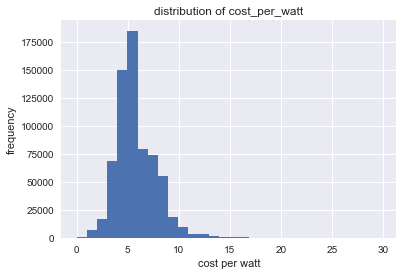

In [19]:
## some bad data at the high and low ends.
dfRes.cost_per_watt.plot(kind='hist', bins=30)
plt.xlabel('cost per watt')
plt.ylabel('frequency')
plt.title('distribution of cost_per_watt');

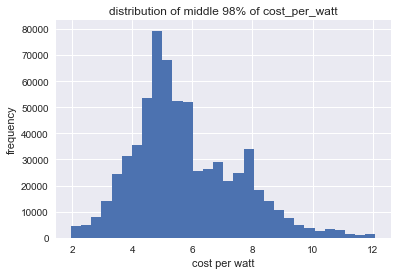

In [20]:
mid98(dfRes.cost_per_watt).plot(kind='hist', bins=30)
plt.xlabel('cost per watt')
plt.ylabel('frequency')
plt.title('distribution of middle 98% of cost_per_watt');

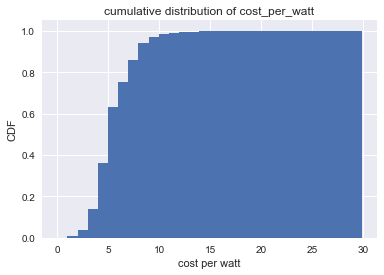

In [21]:
dfRes.cost_per_watt.plot(kind='hist', bins=30, cumulative=True, normed=True)
plt.xlabel('cost per watt')
plt.ylabel('CDF')
plt.title('cumulative distribution of cost_per_watt');

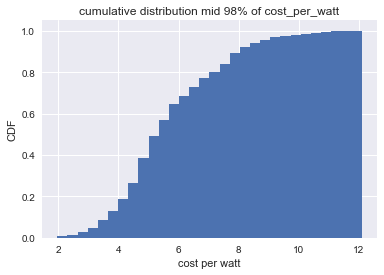

In [22]:
mid98(dfRes.cost_per_watt).plot(kind='hist', bins=30, cumulative=True, normed=True)
plt.xlabel('cost per watt')
plt.ylabel('CDF')
plt.title('cumulative distribution mid 98% of cost_per_watt');

###### cost
Presumably this is the total cost of the installation.

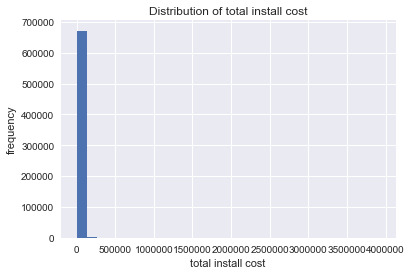

In [23]:
# something funny here.  Summary stats say median is $30k.  Mean is double that.
dfRes.cost.plot(kind='hist', bins=30)
plt.xlabel('total install cost ')
plt.ylabel('frequency')
plt.title('Distribution of total install cost');

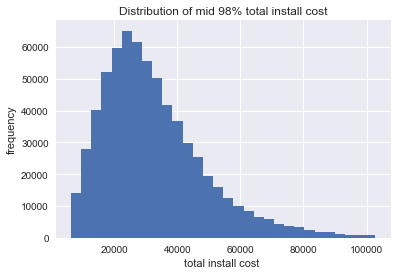

In [24]:
# without the bottom and top 1%
mid98(dfRes.cost).plot(kind='hist', bins=30)
plt.xlabel('total install cost ')
plt.ylabel('frequency')
plt.title('Distribution of mid 98% total install cost');

##### size
Total kilowatts for installation.

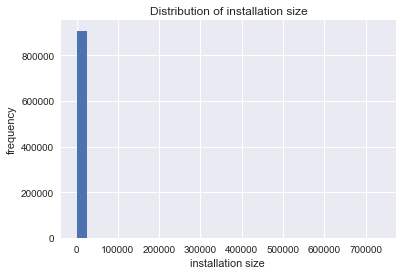

In [25]:
# looks a lot like the cost distribution
dfRes.size_kw.plot(kind='hist', bins=30)
plt.xlabel('installation size ')
plt.ylabel('frequency')
plt.title('Distribution of installation size');

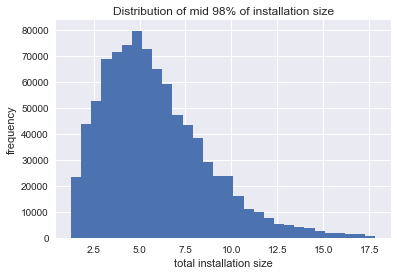

In [26]:
# much more like data
mid98(dfRes.size_kw).plot(kind='hist', bins=30)
plt.xlabel('total installation size')
plt.ylabel('frequency')
plt.title('Distribution of mid 98% of installation size');

---

### Commentary on data quality for cost_per_watt, cost and size

Breaking out the data for residential did not clean up the distributions.  Since they are far and away the largest group, this might not be surprising.  Masking away the top and bottom 1% seem to bring us much closer to a working set.  It will be interesting to see what happens when the same approach is applied to commercial installations, the next largest group.

### Breaking here...

### look at the relationship between cost-per-watt, cost and size(kw)
If this data is good, size_kw * cost/watt ~= cost.  We want to find out if it's true

In [27]:
# ignore before 2004 for now
def after(df=dfFull, year=2004):
    return dfFull.loc[dfFull.index > pd.to_datetime(year)]    

In [28]:
# keep going on variables; Come back to this.
# (size_kw * cost_per_watt) * 1000 ~= cost
# thing =  (after().size_kw * after().cost_per_watt * 1000)/after().cost

<a id="Geo"></a> 
#### Geography
```
* state                          1020521 non-null object
* zipcode                        1020516 non-null float64
* city                           798954 non-null object
* county                         998652 non-null object
```

In [29]:
dfFull[['state', 'zipcode', 'city', 'county']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1020516 entries, 1909-07-07 to 2017-11-25
Data columns (total 4 columns):
state      1020516 non-null object
zipcode    1020516 non-null int64
city       798954 non-null object
county     998649 non-null object
dtypes: int64(1), object(3)
memory usage: 38.9+ MB


##### State

In [30]:
dfFull.state.describe()
# 63% of the data is California; there are perhaps some typos (55 states?)

count     1020516
unique         52
top            CA
freq       626820
Name: state, dtype: object

##### City

In [31]:
# 11k cities; not sure what I can do these.
dfFull.city.describe()

count        798954
unique        11294
top       SAN DIEGO
freq          13681
Name: city, dtype: object

##### County

In [32]:
# almost 10% in LA county.
dfFull.county.describe()

count          998649
unique           1039
top       Los Angeles
freq            82647
Name: county, dtype: object

##### Zipcode

In [33]:
# hmmm, shouldn't be any zeros but there are.  Only 1.
# this should probably be int; actually s.b. 5-char string.
dfFull.zipcode.describe()

count    1.020516e+06
mean     7.195138e+04
std      3.548949e+04
min      0.000000e+00
25%      7.500200e+04
50%      9.202800e+04
75%      9.372200e+04
max      9.973700e+04
Name: zipcode, dtype: float64

In [34]:
(dfFull.zipcode == 0).sum()

1

<a id="#Other"></a>
### Other

Installation type tells us whether or not an installation is at a home or business, school, government, etc.  There are potentially some interesting questions to ask about relative pricing among these groups, even though that's not the main thrust of this effort (residential).  If larger organizations pay less, it could provide a floor for residential installations.

Do costs vary by installer?  It may be possible to say something sensible depending on the data.

Is solar less or more expensize in new construction?

Do third party owners pay more or less for PV installations?  How many 3rd party installation occur and when?


type                           1020516 non-null object
install_type                   977940 non-null object
installer                      702466 non-null object
new_constr                     27106 non-null float64
tracking                       1930 non-null float64
3rdparty                       306993 non-null float6

##### Installer

In [35]:
### 11k installers; that's a lot
dfFull.installer.describe()

count        702466
unique        10956
top       SolarCity
freq         168125
Name: installer, dtype: object

In [36]:
# let's look at the top 30
# wonder if DIY pays less?  how much?
dfFull.installer.value_counts().head(30)

SolarCity                            168125
Vivint                                41615
Sunpower                              19925
Verengo                               16396
Sungevity                             14939
Rec Solar                             14291
PetersenDean                          11235
RGS/Real Goods                        10951
Sunrun                                 9968
Grid Alternatives                      8119
Trinity Heating & Air                  7966
Roof Diagnostics Solar & Electric      6012
Self                                   5345
American Solar Direct                  4917
Direct Energy Solar                    4761
American Solar Electric                4453
Future Energy Corp                     4215
Sullivan Solar Power                   4186
Baker Electric                         3591
Solar Service Center                   3295
A1 Solar Power                         3180
Next Step Living                       3172
Solar Company                   

In [37]:
dfFull.installer.value_counts().head(100).cumsum()

SolarCity                             168125
Vivint                                209740
Sunpower                              229665
Verengo                               246061
Sungevity                             261000
Rec Solar                             275291
PetersenDean                          286526
RGS/Real Goods                        297477
Sunrun                                307445
Grid Alternatives                     315564
Trinity Heating & Air                 323530
Roof Diagnostics Solar & Electric     329542
Self                                  334887
American Solar Direct                 339804
Direct Energy Solar                   344565
American Solar Electric               349018
Future Energy Corp                    353233
Sullivan Solar Power                  357419
Baker Electric                        361010
Solar Service Center                  364305
A1 Solar Power                        367485
Next Step Living                      370657
Solar Comp

##### new_constr 

In [38]:
# presumably this is 1 if a new construction project; otherwise NA
# should be boolean?
dfFull.new_constr.describe()

count    27106.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: new_constr, dtype: float64

##### tracking

In [39]:
# presumably this is 1 if project has tracking; otherwise NA, meaning fixed
# should be boolean?
dfFull.tracking.describe()

count    1930.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: tracking, dtype: float64

##### 3rdparty 

In [40]:
# another value that could be boolean; there is a pretty large number of these

dfFull['3rdparty'].describe()

count    306990.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: 3rdparty, dtype: float64

<a id="possible"></a>
### Examine columns - part ii: other possibly usable fields

##### dfFull.year (as opposed to the index)

In [41]:
# What is the 'year' variable.
# Only 68 non-null, while date_installed is fully populated
# This may be a field internal to NREL/LBNL
print(list(dfFull[dfFull.year.notnull()].year))

['1/1/1999', '1/1/1999', '1/1/1999', '1999', '1999', '1999', '1/1/2000', '1/1/2000', '1/1/2000', '1/3/2000', '1/1/2001', '1/1/2001', '1/1/2001', '1/1/2001', '1/1/2002', '1/1/2002', '1/1/2002', '1/1/2002', '1/1/2003', '1/1/2004', '1/1/2004', '1/1/2005', '1/1/2005', '1/1/2005', '1/1/2006', '1/1/2006', '1/1/2006', '1/1/2006', '1/1/2006', '1/1/2006', '1/1/2006', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/1/2007', '1/2/2007', '1/1/2008', '1/1/2008', '1/1/2008', '1/1/2008', '1/1/2008', '1/1/2008', '1/1/2008', '1/1/2008', '1/1/2008']


##### Incentive_program_name

In [42]:
### incentive program name
### data manual says these orgs may have provided the data
dfFull.incentive_prog_names.value_counts()

California Public Utilities Commission (Non-CSI Net Metered Systems)          260940
California Public Utilities Commission (California Solar Initiative)          148988
New York State Energy Research and Development Authority                       44012
Arizona Public Service                                                         40647
Massachusetts Clean Energy Center                                              36810
New Jersey Board of Public Utilities (SREC Program)                            34168
California Energy Commission (Emerging Renewables Program)                     27952
Massachusetts Department of Energy Resources                                   24828
Los Angeles Department of Water & Power                                        19757
California Energy Commission (New Solar Homes Partnership)                     17286
Connecticut Clean Energy Finance and Investment Authority                      15746
Salt River Project                                               

##### Appraised

In [43]:
### appraised
### data manual cautions that appraised values do not represent a transaction cost 
### (i.e. may not reflect market price)
dfFull.appraised.value_counts()

True    224036
Name: appraised, dtype: int64

##### dfFull.lbnl_tts and dfFull.lbnl_tts_version_year

In [44]:
### these next 2 have to do with LBNL's Tracking the Sun project
### probably of no use 
dfFull.lbnl_tts.value_counts()

True    797958
Name: lbnl_tts, dtype: int64

In [45]:
dfFull.lbnl_tts_version_year.value_counts()

2016.0    797958
Name: lbnl_tts_version_year, dtype: int64

##### utility and utility_clean

In [46]:
### what is the difference between utility and utility_clean?
### 
print(dfFull.utility.equals(dfFull.utility_clean))
print(dfFull.utility.count())
print(dfFull.utility.value_counts())

False
2117
PPL Electric Utilities                              415
PECO                                                354
Oncor                                               207
Met-Ed                                              202
Nevada Power                                        169
Sierra Pacific Power Company                        140
CVPS Corp                                           128
GMP Corp.                                            73
ComEd                                                72
Allegheny (West Penn)                                45
Sierra Pacific                                       42
First Energy (Pennsylvania Electric Co)              30
Other                                                20
AmerenIP                                             16
Duquesne                                             16
Wash. Elec Co-op                                     16
VT Elec. Co-op                                       14
AmerenCILCO                          

In [47]:
# Let's count then look at some of these pairs.
# okay, they are all the same, except 2k don't have utility_clean
funnyUtils = dfFull[dfFull.utility.notnull() & (dfFull.utility != dfFull.utility_clean)]
print(funnyUtils[['utility', 'utility_clean']].count())
print(funnyUtils[['utility', 'utility_clean']].head(10))

utility          2117
utility_clean       0
dtype: int64
                  utility utility_clean
date_installed                         
2004-01-15      GMP Corp.           NaN
2004-02-13      GMP Corp.           NaN
2004-02-19      CVPS Corp           NaN
2004-05-07      CVPS Corp           NaN
2004-05-28      CVPS Corp           NaN
2004-06-11      CVPS Corp           NaN
2004-07-02      GMP Corp.           NaN
2004-07-23      CVPS Corp           NaN
2004-07-23      CVPS Corp           NaN
2004-07-30      GMP Corp.           NaN


##### tech_1

In [48]:
### Possibly of interest
dfFull.tech_1.value_counts()

Poly              350761
Mono              215216
crystalline         7439
Mono + a-Si         5063
CIGS                1097
CdTe                 664
a-Si                 480
a-Si + Micro-c        60
Thin Film             52
CIS                   43
multiple              42
Name: tech_1, dtype: int64

##### Model_1_clean

In [49]:
### model1_clean
### hmmm.  
### Now, I see: the string "multiple matches" occurs 100k times.
### Hard to see how I could make use of this.
### I think these values are PV panel part numbers.
dfFull.model1_clean.value_counts().head()

multiple matches    96988
SPR-327NE-WHT-D     21787
REC260PE            20071
TSM-250PA05.18      11806
KU265-6ZPA           8537
Name: model1_clean, dtype: int64

In [50]:
dfFull.model1_clean.count()

580917

##### Annual solar production

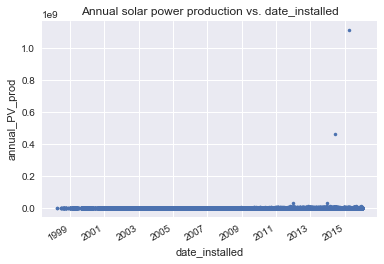

In [51]:
### annual solar power production.  units are kwH/yr
dfFull.annual_PV_prod.plot(marker='.', linestyle='none')
plt.xlabel('date_installed')
plt.ylabel('annual_PV_prod')
plt.title('Annual solar power production vs. date_installed');

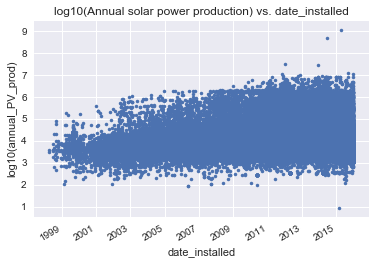

In [52]:
### can I put this on log scale
np.log10(dfFull.annual_PV_prod).plot(marker='.', linestyle='none')
plt.xlabel('date_installed')
plt.ylabel('log10(annual_PV_prod)')
plt.title('log10(Annual solar power production) vs. date_installed');

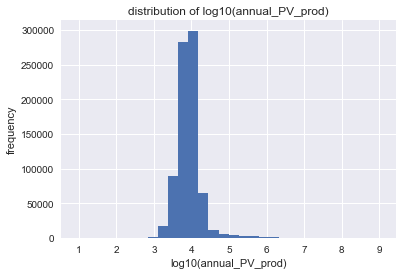

In [53]:
### now a histogram, please.
np.log10(dfFull.annual_PV_prod).plot(kind='hist', bins=30)
plt.xlabel('log10(annual_PV_prod)')
plt.ylabel('frequency')
plt.title('distribution of log10(annual_PV_prod)');

In [54]:
### Okay, a few outliers on the high size
print(dfFull[dfFull.annual_PV_prod > 10 ** 7]['annual_PV_prod'])

date_installed
2011-11-07    1.067801e+07
2011-12-30    3.063050e+07
2013-12-13    2.868939e+07
2014-06-11    4.646728e+08
2015-04-15    1.113476e+09
2015-08-31    1.257042e+07
2015-12-18    1.102429e+07
Name: annual_PV_prod, dtype: float64


In [55]:
### Outliers on the low side.  That's a lot cheaper to do... 
print(dfFull[dfFull.annual_PV_prod < 10 ** 3]['annual_PV_prod'].count())

865


##### Annual_insolation

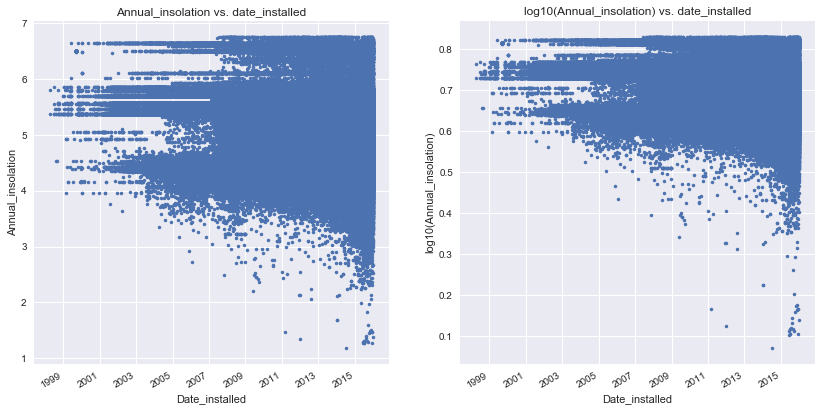

In [56]:
### This has no impact on price.
### Curiosity only.  Annual_insolation units are kWh/m2/day or something like that.
### Data docs say they calculate it from the zipcode.  This is apparently an annual
### number and they document a daily number
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

### annual insolation units are kwH/yr
dfFull.annual_insolation.plot(marker='.', linestyle='none', ax=axs[0])
axs[0].set_xlabel('Date_installed')
axs[0].set_ylabel('Annual_insolation')
axs[0].set_title('Annual_insolation vs. date_installed');
np.log10(dfFull.annual_insolation).plot(marker='.', linestyle='none', ax=axs[1])
axs[1].set_xlabel('Date_installed')
axs[1].set_ylabel('log10(Annual_insolation)')
axs[1].set_title('log10(Annual_insolation) vs. date_installed');

##### rebate 

In [57]:
### This column is obj.  What kinds of things does it contain??
theRebates = dfFull.rebate.dropna()
theRebates.head()
### no more NA in theRebates
theRebates.count()

386698

In [58]:
### most of them are floats; looks like a couple of K are something else
theRebates.apply(lambda item: True if type(item) == type(123.45) else False).sum()

363246

In [59]:
# vector that will select the floats
myVec = theRebates.apply(lambda item: True if type(item) == type(123.45) else False)

In [60]:
# look at the ones that aren't floats
theRebates[~myVec].head(3)
# funny they look like floats, but...

date_installed
2010-05-05    4144.0
2010-05-05    2433.0
2010-05-05    5730.0
Name: rebate, dtype: object

In [61]:
# they're really strings
theRebates[~myVec].head(3).apply(type)

date_installed
2010-05-05    <class 'str'>
2010-05-05    <class 'str'>
2010-05-05    <class 'str'>
Name: rebate, dtype: object

In [62]:
# defer this for now.  handle in cleaning phase
# check the types
# same number as I have above for floats.
theRebates.apply(type).value_counts()

<class 'float'>    363246
<class 'str'>       23452
Name: rebate, dtype: int64

##### sales_tax_cost
Defering for now. I don't think it's a large factor in cost, though could matter for high tax states (e.g. CA) For completeness, I'll look at this, but it looks like there's bad data (off by factor of 10 or 100).  The excel version of this field might be cleaned up.

In [63]:
full_stc = dfFull.sales_tax_cost.dropna()

In [64]:
# they're supposed to be floats
full_stc.head()

date_installed
2000-01-03     787.769510
2000-01-06     384.595726
2000-01-06     350.862362
2000-01-06    1237.921639
2000-01-20     262.098811
Name: sales_tax_cost, dtype: float64

In [65]:
# std is very high; something's funny.
# did someone use a percent multiplier rather than than the decimal?
# clearly a calculated value.  Actuals would be 2 decimals.
dfFull.sales_tax_cost.describe()

count    355309.000000
mean       2657.135224
std       14579.815550
min          10.130237
25%         764.153153
50%        1118.821468
75%        1674.020650
max      872902.116200
Name: sales_tax_cost, dtype: float64

In [66]:
# how many > 3 x mean
full_stc[full_stc > 3 * 2657].count()

10343

In [67]:
# how many > 10 x mean
full_stc[full_stc > 10 * 2657].count()

4083

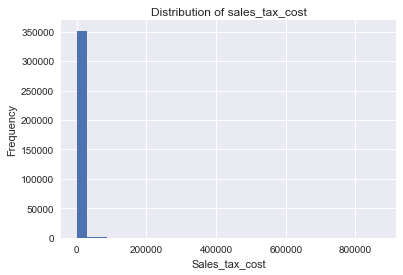

In [68]:
# let's see what the distribution is like.
# pretty hard to believe; though cost might prove informative
full_stc.plot(kind='hist', bins=30)
plt.xlabel('Sales_tax_cost')
plt.ylabel('Frequency')
plt.title('Distribution of sales_tax_cost');

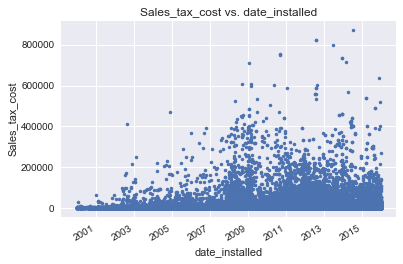

In [69]:
full_stc.plot(marker='.', linestyle='none')
plt.xlabel('date_installed')
plt.ylabel('Sales_tax_cost')
plt.title('Sales_tax_cost vs. date_installed');

##### Tilt and Azimuth
These are features of the installation (generally calculated to maximize total output) but not one that increases cost.

In [70]:
theTilts = dfFull.tilt1.dropna()

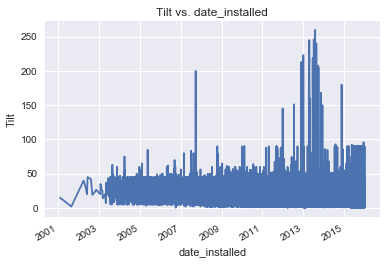

In [71]:
### hard to interpret
theTilts.plot()
plt.xlabel('date_installed')
plt.ylabel('Tilt')
plt.title('Tilt vs. date_installed');

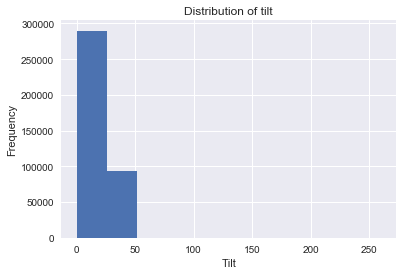

In [72]:
# distribution please
# okay that's better
theTilts.plot(kind='hist')
plt.xlabel('Tilt')
plt.ylabel('Frequency')
plt.title('Distribution of tilt');

In [73]:
azi = dfFull.azimuth1.dropna(); azi.head()

date_installed
1999-12-01    180.0
2001-02-02    270.0
2001-04-23    180.0
2001-04-30    180.0
2001-08-23    180.0
Name: azimuth1, dtype: float64

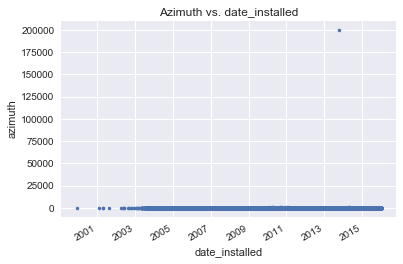

In [74]:
azi.plot(marker='.', linestyle='none')
plt.xlabel('date_installed')
plt.ylabel('azimuth')
plt.title('Azimuth vs. date_installed');

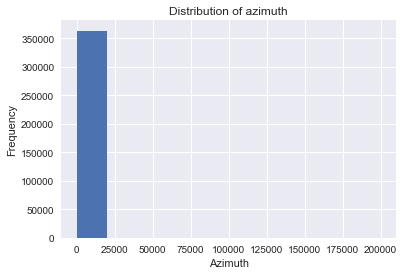

In [75]:
azi.plot(kind='hist')
plt.xlabel('Azimuth')
plt.ylabel('Frequency')
plt.title('Distribution of azimuth');

In [76]:
# bad data
azi[azi > 360.0]

date_installed
2009-11-18       390.0
2009-12-21       390.0
2010-02-03       450.0
2010-03-05       390.0
2010-03-05       374.0
2010-03-09       390.0
2010-03-24       370.0
2010-03-31       420.0
2010-04-14       400.0
2010-05-07       370.0
2010-05-17       368.0
2010-06-08       378.0
2010-06-09       390.0
2010-06-28       380.0
2010-07-30       363.0
2010-08-13       380.0
2010-09-07       405.0
2010-09-24       405.0
2010-12-17       450.0
2011-01-31       400.0
2011-02-18       372.0
2011-04-15       367.0
2013-10-16    200100.0
2014-04-24       420.0
2014-05-01       540.0
Name: azimuth1, dtype: float64

##### tracking_type

There is another column called tracking (boolean).  There's probably not enough data here to do anything with.

In [77]:
dfFull.tracking_type.describe()

count     526055
unique         4
top        Fixed
freq      524383
Name: tracking_type, dtype: object

In [78]:
dfFull.tracking_type.value_counts()

Fixed          524383
Single-Axis       844
Dual-Axis         541
Mixed             287
Name: tracking_type, dtype: int64

##### manuf_1, manuf_2, manuf_3

List of manufacturers of the PV modules.  Could be useful, but since the mixes aren't given, it's hard to understand what to do with it.  More analysis could point the way (e.g. does the same manufacturer show up in multiple variables?  Are these all mixed?)

In [79]:
print(dfFull.manuf1_clean.describe()); print()
print(dfFull.manuf1_clean.value_counts())

count       201120
unique          22
top       SunPower
freq         83310
Name: manuf1_clean, dtype: object

SunPower                              83310
Canadian Solar                        47628
Sharp                                 33129
LG Electronics Solar Cell Division    11639
AU Optronics                           6294
ET Solar Industry                      5088
Schuco USA                             4699
Phono Solar Technology                 3004
Andalay Solar                          1595
GE Energy                              1572
MAGE Solar                             1558
Chint Solar (Zhejiang)                  563
Siemens                                 330
Westinghouse Solar                      266
Open Energy                             152
Yes! Solar                              143
Helios USA                              129
Honeywell                                11
Powercom                                  4
CFM                                       3
GreenVolt

In [80]:
print(dfFull.manuf2_clean.describe()); print()
print(dfFull.manuf2_clean.value_counts())

count       231606
unique         183
top       SunPower
freq         83629
Name: manuf2_clean, dtype: object

SunPower                                               83629
Canadian Solar                                         48371
Sharp                                                  33218
LG Electronics Solar Cell Division                     10358
Trina Solar                                             9893
AU Optronics                                            6327
ET Solar Industry                                       5136
Kyocera Solar                                           4993
Schuco USA                                              4712
Phono Solar Technology                                  3008
REC Solar                                               2912
Yingli Green Energy                                     2265
Andalay Solar                                           1604
SolarWorld                                              1573
GE Energy                          

In [81]:
print(dfFull.manuf3_clean.describe())
print(dfFull.manuf3_clean.value_counts())

count       209652
unique         121
top       SunPower
freq         83329
Name: manuf3_clean, dtype: object
SunPower                                                 83329
Canadian Solar                                           47680
Sharp                                                    33134
LG Electronics Solar Cell Division                       11311
AU Optronics                                              6293
ET Solar Industry                                         5089
Schuco USA                                                4700
Phono Solar Technology                                    3006
Trina Solar                                               2869
Kyocera Solar                                             1977
Andalay Solar                                             1596
GE Energy                                                 1572
MAGE Solar                                                1554
REC Solar                                                 1008
Yingli G

##### inv_man_clean     
Manufacturer of the inverter.  This is potentially of interest as the inverter is one of the highest cost components of the installation.

In [82]:
inv_man = dfFull.inv_man_clean.dropna()
print(inv_man.describe())

count        49932
unique          22
top       SunPower
freq         42793
Name: inv_man_clean, dtype: object


In [83]:
inv_man.value_counts()

SunPower                              42793
Solectria                              3218
Sharp                                  1873
Schuco USA                             1185
AU Optronics                            156
GE Energy                               131
MAGE Solar                              108
Yes! Solar                               99
CFM                                      80
Siemens                                  72
ET Solar Industry                        56
Powercom                                 34
Open Energy                              29
Canadian Solar                           26
LG Electronics Solar Cell Division       25
Phono Solar Technology                   19
Westinghouse Solar                       10
Honeywell                                 7
GreenVolts                                7
Andalay Solar                             2
Helios USA                                1
Chint Solar (Zhejiang)                    1
Name: inv_man_clean, dtype: int6

##### reported_annual_energy_prod

There's some doubt in my mind whether these are properly reported.  Median is 8.25k.  Presumably that is 8.25kw.  That sounds like a daily figure.  The high values may not have been properly normalized.

In [84]:
dfFull.reported_annual_energy_prod.describe()

count    2.044260e+05
mean     2.001243e+04
std      1.864276e+05
min      8.841482e-01
25%      5.568851e+03
50%      8.250000e+03
75%      1.190274e+04
max      3.500000e+07
Name: reported_annual_energy_prod, dtype: float64

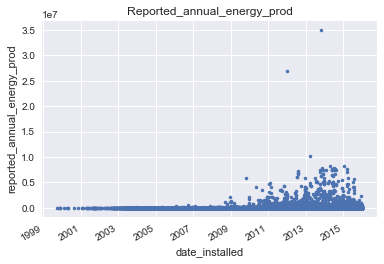

In [85]:
dfFull.reported_annual_energy_prod.plot(marker='.', linestyle='none')
plt.xlabel('date_installed')
plt.ylabel('reported_annual_energy_prod')
plt.title('Reported_annual_energy_prod');

In [86]:
(dfFull.reported_annual_energy_prod > 100000).sum()

2892

1. imports
1. load csv
1. check index has no nulls
1. ensure index is sorted
1. info - 37 cols
1. make dict of column names
1. check it
1. pull out mixed type cols
1. install_type value_counts
1. capture 
1. what fraction of total are residential and commercial
1. make dfRes - residential installs
1. make dfCom - commercial installs
1. describe dfRes cost_per_watt, size_kw, cost
1. define fn to mask top and bottom 1% - mid98
1. describe mid98(dfRes.cost_per_watt)
1. describe dfRes.cost_per_watt
1. look at 1 and 99 percentile values
1. plot dist dfRes.cost_per_watt
1. plot dist mid98(dfRes.cost_per_watt)
1. plot cum dist dfRes.cost_per_watt
1. plot cum dist mid98(dfRes.cost_per_watt)
1. plot dist dfRes.cost
1. plot dist mid98(dfRes.cost)
1. plot dist dfRes.size_kw
1. plot dist mid98(dfRes.size_kw)
1. define fn to mask before 2004
1. note to come back to validate assumptions on relationship between cpw, size, cost
1. get info state, zipcode, city, county
1. describe state col
1. describe city col
1. describe county col
1. describe zipcode col
1. how many zero zipcode?
1. describe installer
1. look at top 30
1. get cumulative sum of top 30
1. describe new_constr
1. describe tracking
1. describe 3rdparty
1. look at 68 values of 'year' col
1. value_counts of incentive_prog_names
1. value_counts of appraised col
1. value_counts lbnl_tts
1. value_counts lbnl_tts_version_year
1. utility and utility clean
    * are they equal - no
    * how many utility - 2117
    * value_counts of utility
1. if they're not equal, what's up?
1. value_counts tech_1
1. peek at beginning of value_counts of model1_clean
1. count of model1_clean
1. plot annual_PV_prod
1. plot log annual_PV_prod
1. plot dist log annual_PV_prod
1. print all aPVprod > 10 ** 7
1. count how many < 1000
1. plot annual_insol and log annual insol
1. count nonnulls in rebates col
1. count floats in rebates col
1. make float mask for this col
1. print the ones that aren't floats
1. what are they?  strings
1. how many strings and floats?
1. capture nonnull sales_tax_cost
1. peek at nonnull sales_tax_cost
1. describe sales_tax_cost
1. how many > 3 * mean
1. how many > 10 * mean
1. plot distribution of nonnull sales_tax_cost
1. scatter plot nonnull sales_tax_cost
1. capture nonnull tilt1
1. plot tilt1
1. plot dist tilt1
1. capture nonnull azimuth1
1. plot azimuth1
1. plot dist azimuth1
1. print values > 360
1. describe tracking_type
1. value_counts tracking_type
1. describe/value_counts manuf1
1. describe/value_counts manuf2
1. describe/value_counts manuf3
1. capture nonnull inv_man_clean
1. value_count inv_man_clean
1. describe reported_annual_energy_prod
1. plot reported_annual_energy_prod
1. how many > 100000

